## Levantar Mejor Red

In [1]:
def find_best_run(path, k=1):

    val_losses = []
    val_metrics = []
    entrenamiento = []

    for file_path in os.listdir(path):

        try:
            with open(os.path.join(path, file_path, 'best_model_info.json'), 'r') as file:
                data = json.load(file)
            
            entrenamiento.append(file_path)
            val_losses.append(data['val_loss'])
            val_metrics.append(data['val_metric'])
        except:
            pass

    indices_ordenados = sorted(range(len(val_metrics)), key=lambda i: val_metrics[i], reverse=False)
    best_value = indices_ordenados[0]
    best_train = entrenamiento[best_value]
    best_train_value = val_metrics[best_value] 

    return best_train, best_train_value

In [2]:
import torch
import os
import json
import sys
import pandapower as pp
import numpy as np
import julia
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

sys.path.append(os.path.abspath('../entrenamiento'))


from omegaconf import OmegaConf

from src.arquitecturas import GNN_global, FCNN_global, GNN_Local
from src.Data_loader import load_net, load_data


import warnings
warnings.filterwarnings('ignore')


red = "30"
arq = "FCNN_global"


dt =  find_best_run(f"./runs/{red}/{arq}/")[0]
cfg = OmegaConf.load(f"./runs/{red}/{arq}/" + dt + "/config.yaml")
weights_dir = f"./runs/{red}/{arq}/" + dt +  "/weights/best_model.pt"



# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
num_nodes, num_gens, edge_index, edge_weights, feature_mask, net= load_net(cfg.data.red,device)


if red == "30":
    net.line["max_loading_percent"] *= 1.1
else:
    net.trafo.tap_pos = 0.0

# Set model
if cfg.model.model == 'GNN_global':
    model = GNN_global(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,num_nodes,num_gens, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_global':
    # Add in and out dimension
    cfg.model.layers[0] *= num_nodes
    model = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'GNN_local':
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_local':
    K = [0 for i in range(len(cfg.model.layers)-1)]
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)

# Load data
train_loader, val_loader, test_loader = load_data(f"../data/red{red}", cfg.training.batch_size, False, cfg.data.normalize_Y,device)
train_loader_norm, val_loader_norm, test_loader_norm = load_data(f"../data/red{red}", cfg.training.batch_size, True, cfg.data.normalize_Y,device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model.load_state_dict(torch.load(weights_dir))

[ Info: Julia version info


Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      "Manjaro Linux"
  uname: Linux 6.6.30-2-MANJARO #1 SMP PREEMPT_DYNAMIC Wed May  8 17:46:43 UTC 2024 x86_64 unknown
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4433 MHz     537765 s        104 s      69431 s   12809126 s       6649 s
       
  Memory: 62.63358688354492 GB (16861.578125 MB free)
  Uptime: 84155.0 sec
  Load Avg:  1.13  0.95  0.76
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, goldmont)
Environment:
  HOME = /home/iboero
  PATH = /home/iboero/miniconda3/envs/proy/bin:/home/iboero/.vscode-server/cli/servers/Stable-dc96b837cf6bb4af9cd736aa3af08cf8279f7685/server/bin/remote-cli:/home/iboero/miniconda3/envs/proy/bin:/home/iboero/miniconda3/condabin:/home/iboero/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsig

[ Info: Julia executable: /home/iboero/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
│     libpython: /home/iboero/miniconda3/envs/proy/lib/libpython3.11.so.1.0
│ Python:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
└     libpython: 


<All keys matched successfully>

## Predecir outputs

In [20]:
import numpy as np
y_pred = []
y_tot = []
x_tot = []
for x,y in test_loader:
    x_tot.append(x.detach().cpu().numpy())
    # y_pred.append(model(x).detach().cpu().numpy())
    y_tot.append(y.detach().cpu().numpy())

for x,y in test_loader_norm:
    y_pred.append(model(x).detach().cpu().numpy())

# Concatenate in dim 0
y_pred = np.concatenate(y_pred, axis=0)
y_tot = np.concatenate(y_tot, axis=0)
y_tot = y_tot[:,:,None]
x_tot = np.concatenate(x_tot, axis=0)


In [30]:
y_tot[100]

array([[0.       ],
       [1.0024836],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0196123],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0231758],
       [1.0162424],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0183221],
       [0.       ],
       [0.       ],
       [0.       ]], dtype=float32)

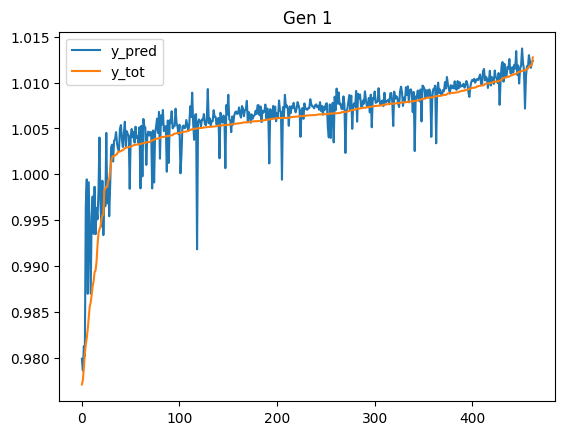

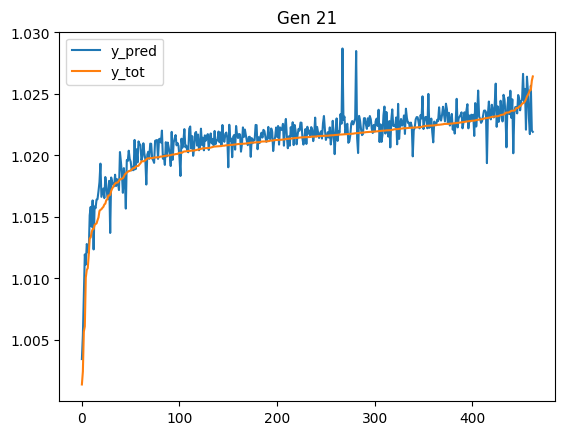

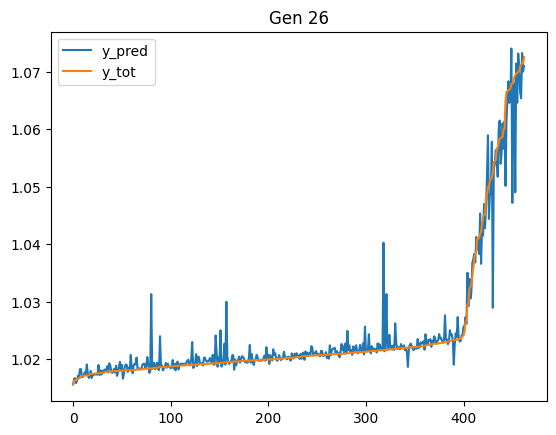

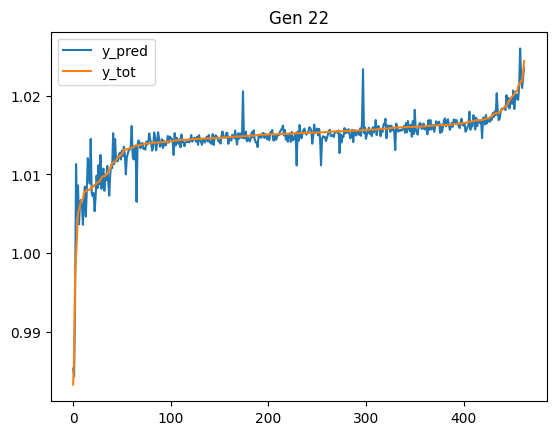

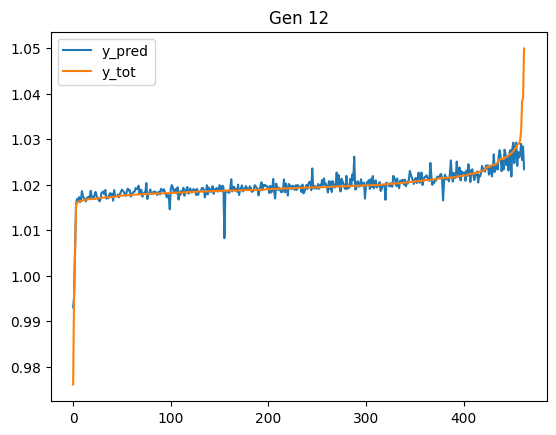

In [23]:
idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
# Plot an histagram per gen of y_pred and y_tot
import matplotlib.pyplot as plt
for i in idx_gens:
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot[:,i].squeeze())
    y_tot_i = y_tot[idx,i].squeeze()
    y_pred_i = y_pred[idx,i].squeeze()
    
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Gen {i}")
    plt.legend()
    plt.show()

## Evaluar

In [24]:



def get_stats(net):
    v_cost = np.abs(net.res_bus.vm_pu.values - 1).sum()
    unfeas_line = (net.res_line.loading_percent.values > 1.05*net.line.max_loading_percent.values).sum()
    unfeas_trafo = 0
    # unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values).sum()
    unfeas_volt = (net.res_bus.vm_pu.values < 0.99*net.bus.min_vm_pu.values).sum() + (net.res_bus.vm_pu.values > 1.01*net.bus.max_vm_pu.values).sum()

    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0:
        unfeas = True
    else:
        unfeas = False
    return v_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt]

v_cost_hist = []
unf_hist = []
unf_cont_hist = []

for idx in range(np.shape(x_tot)[0]):
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
    net.gen.vm_pu = y_pred[idx,idx_gens,0]
    
    pp.runpp(net, enforce_q_lims=True)
    v_cost_pred, unf_pred, unf_const_pred = get_stats(net)

    net.gen.vm_pu = 1
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1  = get_stats(net)
    
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt  = get_stats(net)
    
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])


v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

In [32]:
x_tot[0]

array([[ 0.        ,  0.        ,  0.        ],
       [21.866419  , 16.504911  , 48.010918  ],
       [ 1.7869635 ,  1.515363  ,  0.        ],
       [ 9.808126  ,  1.4219189 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [16.718513  , 13.440828  ,  0.        ],
       [26.327185  , 33.7171    ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 7.16696   ,  1.9612848 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [12.081007  ,  9.413846  ,  0.        ],
       [ 0.        ,  0.        , 13.105263  ],
       [ 7.7011113 ,  1.8555712 ,  0.        ],
       [ 9.923078  ,  3.1428053 ,  0.        ],
       [ 2.954951  ,  1.9443815 ,  0.        ],
       [10.10123   ,  6.0363436 ,  0.        ],
       [ 2.3420136 ,  0.8793812 ,  0.        ],
       [ 8.504982  ,  3.607686  ,  0.        ],
       [ 1.957974  ,  0.82946604,  0.        ],
       [18.831812  ,  8.982975  ,  0.   

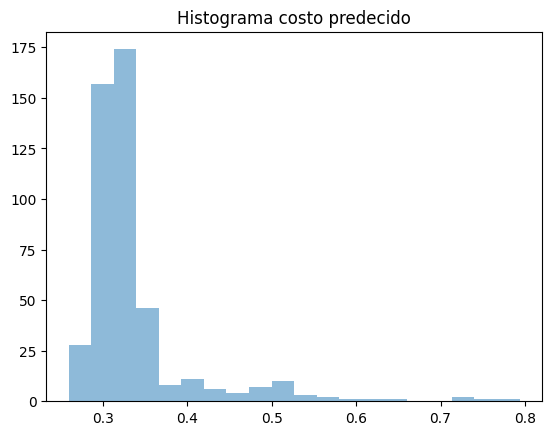

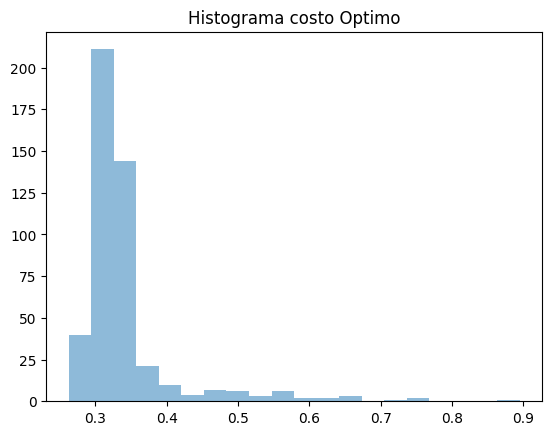

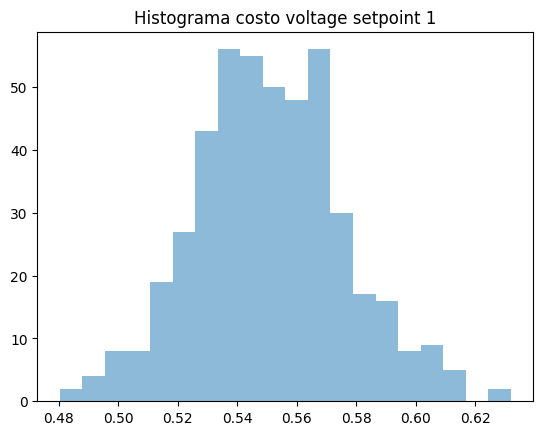

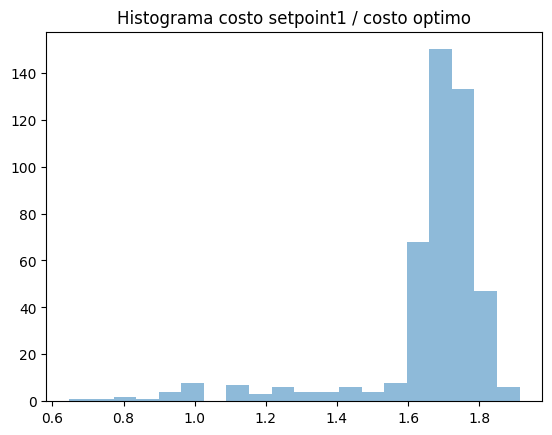

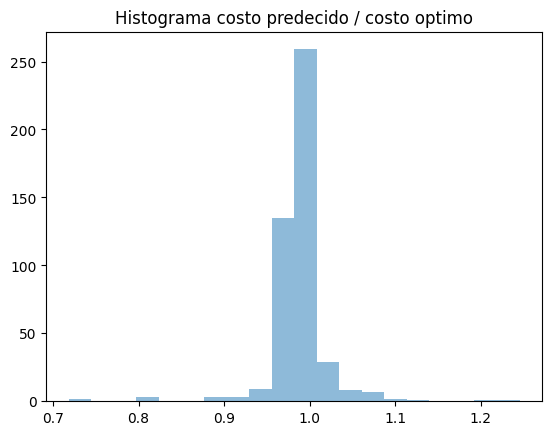

In [25]:
# Histogram of columns of v_cost_hist

plt.title("Histograma costo predecido")
plt.hist(v_cost_hist[:,0], bins=20, alpha=0.5, label='pred/opt')
plt.show()

plt.title("Histograma costo Optimo")
plt.hist(v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo voltage setpoint 1")
plt.hist(v_cost_hist[:,2], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo setpoint1 / costo optimo")
plt.hist(v_cost_hist[:,2] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo predecido / costo optimo")
plt.hist(v_cost_hist[:,0] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

El porcentaje de unfeasibles en el predecido es 0.0
El porcentaje de unfeasibles en el optimo es 0.0
El porcentaje de unfeasibles en el setpoint 1 es 0.10583153347732181


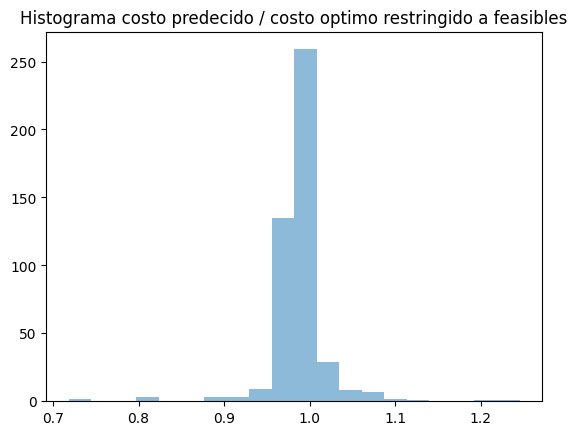

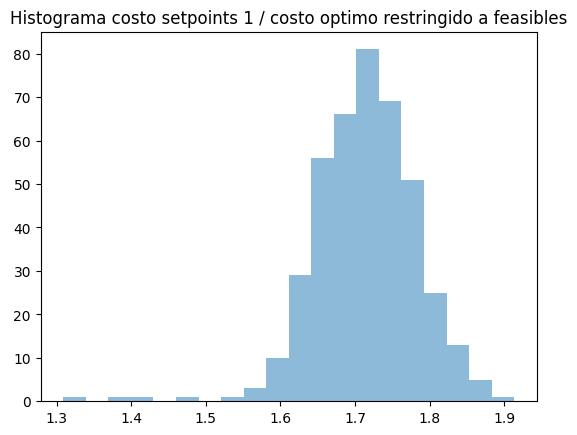

In [26]:
# FEASIBILITY

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [15]:
from copy import deepcopy
idx = np.argmin(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1])


net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
net.gen.vm_pu = y_pred[idx,idx_gens,0]

pp.runpp(net, enforce_q_lims=True)
v_cost_pred, unf_pred, unf_const_pred = get_stats(net)

# net.gen.vm_pu = 1
# pp.runpp(net, enforce_q_lims=True)
# v_cost_v1, unf_v1, unf_const_v1  = get_stats(net)
net_opt = deepcopy(net)
net_opt.gen.vm_pu = y_tot[idx,idx_gens,0]
pp.runpp(net_opt, enforce_q_lims=True)
v_cost_opt, unf_opt, unf_const_opt  = get_stats(net_opt)


In [9]:
net_opt.bus["pm_param/setpoint_v"] = 1.0
net_opt.gen.vm_pu = net.res_gen.vm_pu.values
net_opt.gen.loc[:,"max_p_mw"] = net_opt.gen['p_mw']
net_opt.gen.loc[:,"min_p_mw"] = net_opt.gen['p_mw']
pp.runpm_vstab(net_opt)

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [46]:
np.std(y_tot[:,idx_gens,0] - y_pred[:,idx_gens,0],axis=0)

array([0.00179406, 0.00131854, 0.00126142, 0.00110471, 0.00174544],
      dtype=float32)

In [45]:
np.std(y_tot[:,idx_gens,0] - y_pred[:,idx_gens,0],axis=0)

array([0.00179406, 0.00131854, 0.00126142, 0.00110471, 0.00174544],
      dtype=float32)

## Agregar Normal en Optimo

In [40]:

def get_stats(net):
    v_cost = np.abs(net.res_bus.vm_pu.values - 1).sum()
    unfeas_line = (net.res_line.loading_percent.values > 1.05*net.line.max_loading_percent.values).sum()
    unfeas_trafo = 0
    # unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values).sum()
    unfeas_volt = (net.res_bus.vm_pu.values < 0.99*net.bus.min_vm_pu.values).sum() + (net.res_bus.vm_pu.values > 1.01*net.bus.max_vm_pu.values).sum()

    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0:
        unfeas = True
    else:
        unfeas = False
    return v_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt]

v_cost_hist_pert = []
unf_hist_pert = []
unf_cont_hist_pert = []

for idx in range(np.shape(x_tot)[0]):
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]

    
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt  = get_stats(net)
    
    normal = np.random.normal(0,0.001, size=(len(idx_gens),1))
    net.gen.vm_pu = y_tot[idx,idx_gens,0] + normal
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt_perturbada, unf_opt_perturbada, unf_const_opt_perturbada  = get_stats(net)

    v_cost_hist_pert.append([v_cost_opt, v_cost_opt_perturbada])
    unf_hist_pert.append([unf_opt, unf_opt_perturbada])
    unf_cont_hist_pert.append([unf_const_opt, unf_const_opt_perturbada])


v_cost_hist_pert = np.array(v_cost_hist_pert)
unf_hist_pert = np.array(unf_hist_pert)
unf_cont_hist_pert = np.array(unf_cont_hist_pert)

El porcentaje de unfeasibles en el optimo es 0.0
El porcentaje de unfeasibles en el perturbado es 0.10189075630252101


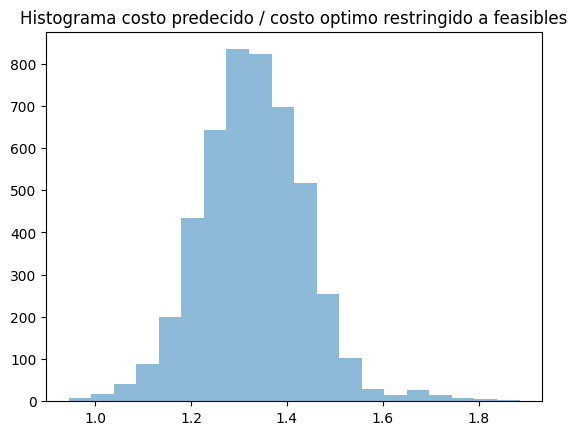

In [43]:

print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist_pert[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el perturbado es {np.mean(unf_hist_pert[:,1], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist_pert[unf_hist[:,1] == 0,1] / v_cost_hist_pert[unf_hist[:,1] == 0,0], bins=20, alpha=0.5, label='pred/v1')
plt.show()


In [44]:
np.mean(v_cost_hist_pert[unf_hist[:,1] == 0,1] / v_cost_hist_pert[unf_hist[:,1] == 0,0])

1.3296022331727602

## Usar promedio del vopt

In [49]:

def get_stats(net):
    v_cost = np.abs(net.res_bus.vm_pu.values - 1).sum()
    unfeas_line = (net.res_line.loading_percent.values > 1.05*net.line.max_loading_percent.values).sum()
    unfeas_trafo = 0
    # unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values).sum()
    unfeas_volt = (net.res_bus.vm_pu.values < 0.99*net.bus.min_vm_pu.values).sum() + (net.res_bus.vm_pu.values > 1.01*net.bus.max_vm_pu.values).sum()

    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0:
        unfeas = True
    else:
        unfeas = False
    return v_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt]

v_cost_hist_mean = []
unf_hist_mean = []
unf_cont_hist_mean = []
y_mean = y_tot[:,idx_gens,0].mean(axis=0)

for idx in range(np.shape(x_tot)[0]):
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]

    
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt  = get_stats(net)
    
    net.gen.vm_pu = y_mean
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt_mean, unf_opt_mean, unf_const_opt_mean  = get_stats(net)

    v_cost_hist_mean.append([v_cost_opt, v_cost_opt_mean])
    unf_hist_mean.append([unf_opt, unf_opt_mean])
    unf_cont_hist_mean.append([unf_const_opt, unf_const_opt_mean])


v_cost_hist_mean = np.array(v_cost_hist_mean)
unf_hist_mean = np.array(unf_hist_mean)
unf_cont_hist_mean = np.array(unf_cont_hist_mean)

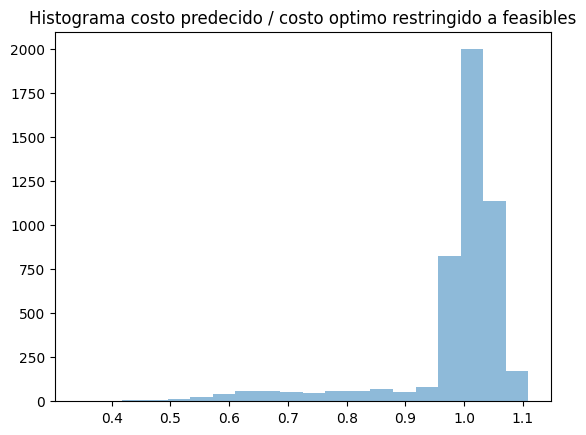

El porcentaje de unfeasibles en el optimo es 0.0
El porcentaje de unfeasibles en el mean es 0.03991596638655462


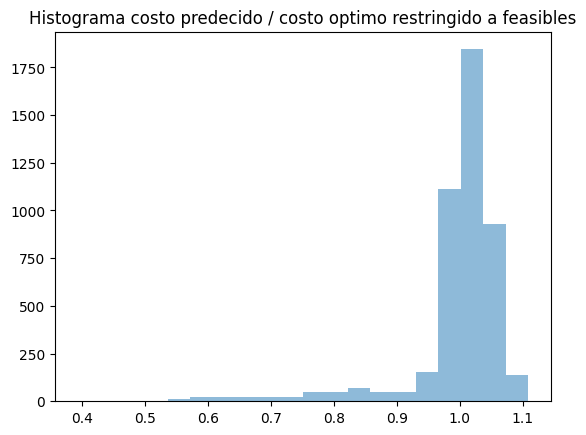

In [63]:
# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist_mean[:,1] / v_cost_hist_mean[:,0], bins=20, alpha=0.5, label='pred/v1')
plt.show()


print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist_mean[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el mean es {np.mean(unf_hist_mean[:,1], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist_mean[unf_hist_mean[:,1] == 0,1] / v_cost_hist_mean[unf_hist_mean[:,1] == 0,0], bins=20, alpha=0.5, label='pred/v1')
plt.show()

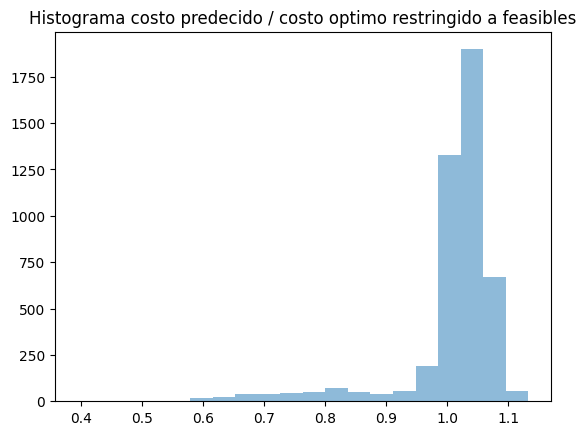

In [86]:

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist_mean[unf_hist_mean[:,1] == 0,1] / v_cost_hist[unf_hist_mean[:,1] == 0,0], bins=20, alpha=0.5, label='pred/v1')
plt.show()

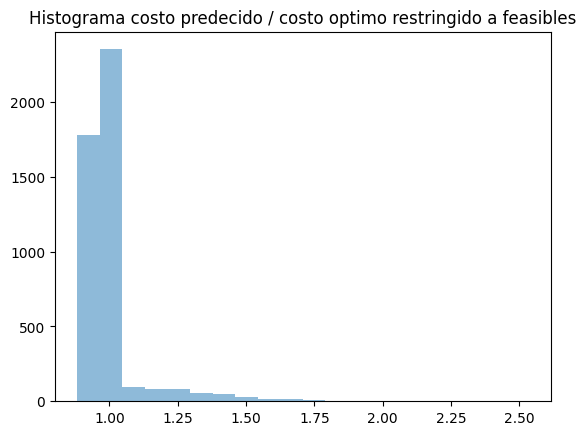

In [91]:

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist_mean[:,1] == 0,0] / v_cost_hist_mean[unf_hist_mean[:,1] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [82]:
idx = np.argmax(v_cost_hist_mean[unf_hist_mean[:,1] == 0,1] / v_cost_hist_mean[unf_hist_mean[:,1] == 0,0])
net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]

net.gen.vm_pu = y_mean
pp.runpp(net, enforce_q_lims=True)
v_cost_opt_mean, unf_opt_mean, unf_const_opt_mean  = get_stats(net)



net.gen.vm_pu = y_tot[idx,idx_gens,0]
pp.runpp(net, enforce_q_lims=True)
v_cost_opt, unf_opt, unf_const_opt  = get_stats(net)
